<a href="https://colab.research.google.com/github/EfthymiosCosta/Neural-Networks-Weight-Uncertainty/blob/main/Emmeran_VI_implementation_play_around.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Create some data to play around with

In [3]:
prior = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([2]))
beta = prior.sample()
likelihood = torch.distributions.normal.Normal(beta, torch.tensor([0.5]))
y = likelihood.sample([100]).squeeze(1)

(array([ 3.,  6.,  6., 13., 29., 21., 13.,  4.,  4.,  1.]),
 array([0.4193536, 0.7114346, 1.0035156, 1.2955966, 1.5876776, 1.8797586,
        2.1718397, 2.4639206, 2.7560017, 3.0480826, 3.3401637],
       dtype=float32),
 <a list of 10 Patch objects>)

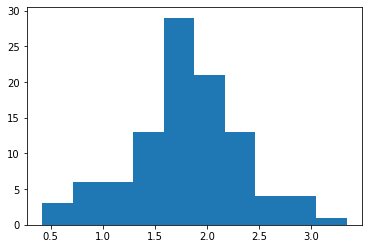

In [4]:
plt.hist(y.numpy())

# Variational Posterior

In [113]:
def train_loop(mu, rho, alpha):
  epsilon = torch.distributions.normal.Normal(torch.zeros(1), torch.eye(1)).sample()[0]
  beta = mu + torch.log(1+torch.exp(rho)) * epsilon
  # q(beta|mu, sigma) = N(beta; mu, sigma)
  # p(beta) = N(beta;0,2)
  # p(y|beta) = N(y; beta, 0.5)
  #grad_mu = -(beta-mu)/(sigma**2) - beta/4  + sum((y-beta)/(0.5**2)) + (beta-mu)/(sigma**2), which simplifies:
  grad_mu =  beta/4 - sum((y-beta)/(0.5**2))
  grad_rho = (-(beta-mu)/(torch.log(1+torch.exp(rho))**2) + beta/4  - sum((y-beta)/(0.5**2))) * epsilon /(1+torch.exp(-rho))        + (-1/(torch.log(1+torch.exp(rho))) + (beta - mu)**2/(torch.log(1+torch.exp(rho))**3))  / (1+torch.exp(-rho))
  mu = mu - alpha*grad_mu
  rho = rho - alpha*grad_rho
  return mu, rho
  


In [170]:
mu = torch.tensor(0)
rho = torch.tensor(1)

In [171]:
for i in range(1000):
  mu, rho = train_loop(mu, rho, 1e-3)

for i in range(1000):
  mu, rho = train_loop(mu, rho, 1e-4)

In [172]:
mu

tensor([1.7911])

In [173]:
torch.log(1+torch.exp(rho))

tensor([0.0535])

In [168]:
true_mu = sum(y)/((0.5**2) * (1/4 + y.size()[0]/(0.5**2)))
true_mu

tensor(1.8019)

In [169]:
true_sigma_2 = 1/(1/4 + y.size()[0]/(0.5**2))
np.sqrt(true_sigma_2)

0.04998438232040613

# Logistic Regression

# Create some data to play around with

In [288]:
prior_sigma_2 = torch.tensor(2)
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(3), prior_sigma_2*torch.eye(3))
beta_star = prior.sample()
beta_star = torch.tensor([0,0.5, -2], dtype = torch.float32)

X = torch.distributions.uniform.Uniform(-3, 3).sample([100, 2])
X = torch.cat((torch.ones([100,1]), X), 1)

#beta_star = torch.tensor([1], dtype = torch.float32)
#X = torch.distributions.uniform.Uniform(-3, 3).sample([100])

likelihood = torch.distributions.bernoulli.Bernoulli(1 / (1 + torch.exp(torch.matmul(X, beta_star))))
#likelihood = torch.distributions.bernoulli.Bernoulli(1 / (1 + torch.exp(X*beta_star)))
y_0_1 = likelihood.sample()

In [289]:
y = 2*y_0_1 - 1

# Variational Posterior

In [336]:
def train_loop(mu, rho, alpha, compute_ELBO = False):
  epsilon = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(3), torch.eye(3)).sample()
  beta = mu + torch.log(1+torch.exp(rho)) * epsilon

  sigma = torch.log(1+torch.exp(rho))

  likelihood_grad_wrt_beta = torch.sum((y.unsqueeze(1).repeat(1,3) * X)/ (1+torch.exp(y*torch.matmul(X, beta))).unsqueeze(1).repeat(1,3), dim = 0)
  prior_grad_wrt_beta =  - beta/prior_sigma_2
  q_grad_wrt_beta = -(beta-mu)/(sigma**2)
  
  q_grad_wrt_mu = (beta-mu)/(sigma**2)
  q_grad_wrt_rho = (-1/sigma + ((beta - mu)**2)/(sigma**3)) / (1+torch.exp(-rho))


  grad_mu = - likelihood_grad_wrt_beta - prior_grad_wrt_beta
  grad_rho = (q_grad_wrt_beta - likelihood_grad_wrt_beta - prior_grad_wrt_beta) * (epsilon/(1+torch.exp(-rho))) + q_grad_wrt_rho

  mu += alpha*grad_mu
  rho += alpha*grad_rho

  if compute_ELBO == True:
    variational_post = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.eye(3) * torch.log(1+torch.exp(rho)))
    ELBO = 0
    for i in range(1000):
      beta_post = variational_post.sample()
      likelihood = torch.distributions.bernoulli.Bernoulli(1 / (1 + torch.exp(torch.matmul(X, beta_post))))
      ELBO += variational_post.log_prob(beta_post) - prior.log_prob(beta_post) - sum(likelihood.log_prob(y_0_1))
    print("-ELBO", ELBO.item() / 1000)

  return mu, rho
  


In [341]:
mu = torch.zeros(3)
rho = torch.zeros(3)

In [342]:
for i in range(5000):
  if i %100 == 0:
    mu, rho = train_loop(mu, rho, 1e-5, compute_ELBO=True)
  else:
    mu, rho = train_loop(mu, rho, 1e-5)

ELBO 109.6804921875
ELBO 105.115984375
ELBO 102.3796875
ELBO 94.90453125
ELBO 91.6598359375
ELBO 85.6295390625
ELBO 84.4496015625
ELBO 78.504765625
ELBO 76.254109375
ELBO 70.191640625
ELBO 68.2821796875
ELBO 63.785546875
ELBO 62.15503515625
ELBO 59.1728125
ELBO 57.134359375
ELBO 54.473109375
ELBO 50.7606796875
ELBO 49.3357109375
ELBO 47.77380078125
ELBO 45.9862578125
ELBO 44.87265625
ELBO 43.30214453125
ELBO 42.792796875
ELBO 42.44877734375
ELBO 41.87457421875
ELBO 41.62522265625
ELBO 41.5237890625
ELBO 41.2081640625
ELBO 41.41350390625
ELBO 41.82706640625
ELBO 41.8718203125
ELBO 42.5716953125
ELBO 42.69919921875
ELBO 43.41826953125
ELBO 43.94640234375
ELBO 44.655078125
ELBO 45.8571328125
ELBO 46.33854296875
ELBO 47.2960703125
ELBO 48.21855859375
ELBO 48.87466015625
ELBO 49.9705703125
ELBO 51.155515625
ELBO 52.3724375
ELBO 52.87632421875
ELBO 54.1422109375
ELBO 55.1498984375
ELBO 56.57619140625
ELBO 58.27959765625
ELBO 59.7618671875


In [338]:
mu

tensor([ -44.9239,  100.0789, -340.8182])

In [339]:
rho

tensor([-0.6453,  0.1124, -2.2649])

In [253]:
import matplotlib.pyplot as plt

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

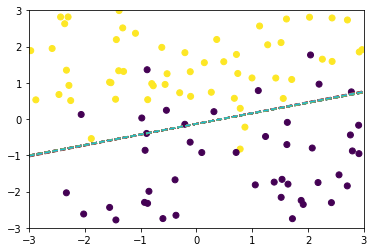

In [340]:
plt.scatter(X[:,1], X[:,2], c = y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
for i in range(100):
  beta = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.eye(3) * torch.log(1+torch.exp(rho))).sample()
  abline(-beta[1]/beta[2], -beta[0]/beta[2])

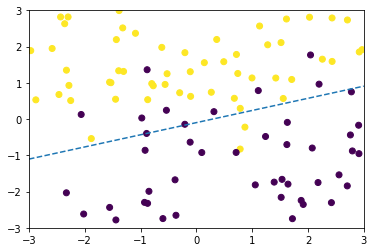

In [333]:
plt.scatter(X[:,1], X[:,2], c = y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
abline(-mu[1]/mu[2], -mu[0]/mu[2])

# Pyro

In [ ]:
pip install pyro-ppl 

In [3]:
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

In [297]:
data = y_0_1

In [298]:
def model(data):
    mu0 = torch.zeros(3)
    sigma0 = torch.eye(3)
    beta = pyro.sample("beta", dist.MultivariateNormal(mu0, sigma0))
    for i in range(data.size(0)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(1 / (1 + torch.exp(torch.matmul(X[i,:], beta)))), obs=data[i])

    # pyro.sample("obs", dist.Bernoulli(1 / (1 + torch.exp(torch.matmul(X, beta)))), obs=data)

In [299]:
def guide(data):
    mu_q = pyro.param("mu_q", torch.zeros(3))
    rho_q = pyro.param("rho_q", torch.zeros(3))
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("beta", dist.MultivariateNormal(mu_q, torch.log(1+torch.exp(rho_q))*torch.eye(3)))

In [278]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

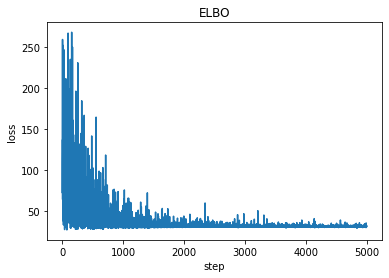

In [300]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.003}),
                     loss=pyro.infer.Trace_ELBO())


losses = []
a = torch.zeros(1, 3)
b = torch.zeros(1, 3)
num_steps = 5000
for t in range(num_steps):
    losses.append(svi.step(data))
    a = torch.cat([a,pyro.param("mu_q").unsqueeze(0)], dim = 0)
    b = torch.cat([b,pyro.param("rho_q").unsqueeze(0)], dim = 0)

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

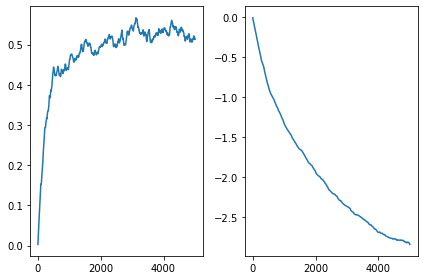

In [301]:
plt.subplot(1,2,1)
plt.plot(a.detach().numpy()[1:,1])

plt.subplot(1,2,2)
plt.plot(b.detach().numpy()[1:,1])
plt.tight_layout()

In [302]:
mu_q = pyro.param("mu_q")
rho_q = pyro.param("rho_q")

In [284]:
mu_q

tensor([-0.0121,  0.6402, -0.6388], requires_grad=True)

In [285]:
rho_q

tensor([-1.3720, -0.8583, -0.9514], requires_grad=True)

In [206]:
 torch.eye(3) * torch.log(1+torch.exp(rho_q))

tensor([[0.0943, 0.0000, 0.0000],
        [0.0000, 0.0599, 0.0000],
        [0.0000, 0.0000, 0.0584]], grad_fn=<MulBackward0>)

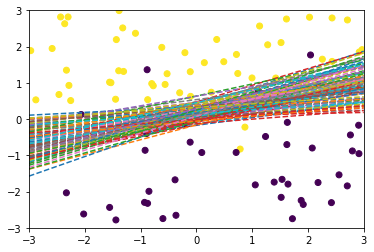

In [303]:
plt.scatter(X[:,1], X[:,2], c = y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
for i in range(100):
  beta = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, torch.eye(3) * torch.log(1+torch.exp(rho_q))).sample()
  abline(-beta[1]/beta[2], -beta[0]/beta[2])

# MNIST 

In [4]:
from keras.datasets import mnist

In [5]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


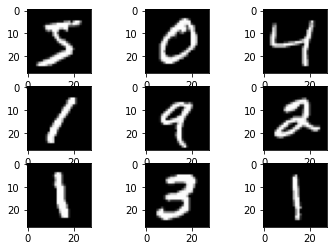

In [6]:
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

# Pyro

In [25]:
data_dim = 28*28
data_input = torch.tensor([train_X.reshape(60000, data_dim)], dtype = torch.float).squeeze(0)
data_output = torch.tensor([train_y], dtype=torch.int64).squeeze(0)

In [27]:
data_output = torch.nn.functional.one_hot(data_output, num_classes = 10)

In [20]:
data_output

tensor([5, 0, 4,  ..., 5, 6, 8], dtype=torch.uint8)

In [57]:
def model(data_input, data_output):
    #mu0 = torch.zeros(data_dim)
    #sigma0 = torch.eye(data_dim)
    #beta = [pyro.sample("beta_{}".format(k), dist.MultivariateNormal(mu0, sigma0)) for k in range(10)]
    #for i in pyro.plate("data_loop", data_input.size(0), subsample_size=10):
    #    # observe datapoint i using the bernoulli likelihood
    #    logits =  torch.FloatTensor([torch.matmul(data_input[i,:], beta_k) for beta_k in beta])
    #    pyro.sample("obs_{}".format(i), dist.Multinomial(logits = logits), obs=torch.FloatTensor([data_output[i] == k for k in range(10)]))


    mu0 = torch.zeros(data_dim)
    sigma0 = torch.eye(data_dim)
    beta = [pyro.sample("beta_{}".format(k), dist.MultivariateNormal(mu0, sigma0)).unsqueeze(1) for k in range(10)]
    beta = torch.cat(beta, dim = 1)
    logits =  torch.matmul(data_input, beta)
    with pyro.plate('observe_data', size=data_input.size(0), subsample_size=5)  as ind:
      pyro.sample('obs', dist.Multinomial(logits = logits.index_select(0, ind)), obs=data_output.index_select(0, ind))
    # pyro.sample("obs", dist.Bernoulli(1 / (1 + torch.exp(torch.matmul(X, beta)))), obs=data)

In [58]:
def guide(data_input, data_output):
  for i in range(10): 
    #exec("mu_q{}".format(i) + " = pyro.param('mu_q{}'.format(i), torch.zeros(data_dim))")
    #exec("rho_q{}".format(i) + " = pyro.param('rho_q{}'.format(i), torch.zeros(data_dim))")
    mu_q0  = pyro.param("mu_q0", torch.zeros(data_dim))
    mu_q1  = pyro.param("mu_q1", torch.zeros(data_dim))
    mu_q2  = pyro.param("mu_q2", torch.zeros(data_dim))
    mu_q3  = pyro.param("mu_q3", torch.zeros(data_dim))
    mu_q4 = pyro.param("mu_q4", torch.zeros(data_dim))
    mu_q5 = pyro.param("mu_q5", torch.zeros(data_dim))
    mu_q6 = pyro.param("mu_q6", torch.zeros(data_dim))
    mu_q7 = pyro.param("mu_q7", torch.zeros(data_dim))
    mu_q8  = pyro.param("mu_q8", torch.zeros(data_dim))
    mu_q9 = pyro.param("mu_q9", torch.zeros(data_dim))

    rho_q0 = pyro.param("rho_q0", torch.zeros(data_dim))
    rho_q1 = pyro.param("rho_q1", torch.zeros(data_dim))
    rho_q2 = pyro.param("rho_q2", torch.zeros(data_dim))
    rho_q3 = pyro.param("rho_q3", torch.zeros(data_dim))
    rho_q4  = pyro.param("rho_q4", torch.zeros(data_dim))
    rho_q5  = pyro.param("rho_q5", torch.zeros(data_dim))
    rho_q6 = pyro.param("rho_q6", torch.zeros(data_dim))
    rho_q7  = pyro.param("rho_q7", torch.zeros(data_dim))
    rho_q8  = pyro.param("rho_q8", torch.zeros(data_dim))
    rho_q9  = pyro.param("rho_q9", torch.zeros(data_dim))
  for i in range(10):
    pyro.sample("beta_{}".format(i), dist.MultivariateNormal(locals()['mu_q' + str(i)], torch.log(1+torch.exp(locals()['rho_q' + str(i)]))*torch.eye(data_dim)))

190992224.13713378
167821661.18482053
201878830.64751583
168866674.2559387
171883513.5746948
211829008.85550538
157957638.90236208
179110196.08557737
214620174.69218746
155297753.8162414
176108683.65206295
127999598.12086181
164841843.5486145
232005794.5095398
192513455.3633789
200209129.2802063
188069752.96362302
201965918.64330444
187779339.26970822
154050469.8058899
182707646.9168396
179560572.7787659
158537219.0464905
167795564.79437256
187164161.64973754
178422406.6419983
192392191.82138672
178002810.845874
172615303.53323364
194290567.230835
161530987.55610353
152361739.13403323
172040355.84592286
190302525.4263733
164965131.56044313
169587332.90717772
146390082.03001708
227987667.48980102
212299697.84789428
181536977.81158447
201530517.28775635
197396793.008374
182576469.47836304
145030637.72383422
169161927.60301512
199669501.6658753
176757355.85712892
190350646.19681397
199290040.06433105
173032010.41348878
163054368.3814209
194669783.7819763
156268384.59273684
146555583.09525

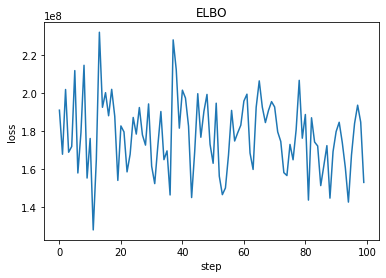

In [59]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.0001}),
                     loss=pyro.infer.Trace_ELBO(10))


losses = []
num_steps = 100
for t in range(num_steps):
    losses.append(svi.step(data_input, data_output))
    #losses.append(svi.step(data_input[:1000,:], data_output[:1000]))
    print(losses[-1])

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

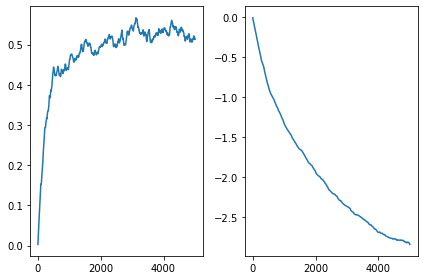

In [ ]:
plt.subplot(1,2,1)
plt.plot(a.detach().numpy()[1:,1])

plt.subplot(1,2,2)
plt.plot(b.detach().numpy()[1:,1])
plt.tight_layout()

In [ ]:
mu_q = pyro.param("mu_q")
rho_q = pyro.param("rho_q")

In [ ]:
mu_q

tensor([-0.0121,  0.6402, -0.6388], requires_grad=True)

In [ ]:
rho_q

tensor([-1.3720, -0.8583, -0.9514], requires_grad=True)

In [ ]:
 torch.eye(3) * torch.log(1+torch.exp(rho_q))

tensor([[0.0943, 0.0000, 0.0000],
        [0.0000, 0.0599, 0.0000],
        [0.0000, 0.0000, 0.0584]], grad_fn=<MulBackward0>)

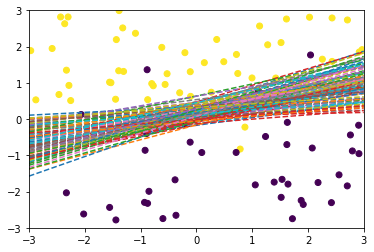

In [ ]:
plt.scatter(X[:,1], X[:,2], c = y)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
for i in range(100):
  beta = torch.distributions.multivariate_normal.MultivariateNormal(mu_q, torch.eye(3) * torch.log(1+torch.exp(rho_q))).sample()
  abline(-beta[1]/beta[2], -beta[0]/beta[2])

# suriyadeepan bayesian NN on MNIST

In [60]:
import pyro
import pyro.distributions as pdist
import pyro.optim as optim

import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

from pyro.infer import Trace_ELBO, SVI

from random import shuffle
import argparse
# from tqdm import tqdm

In [62]:
def random_sample(t, k):
  x, y = t
  indices = torch.randperm(len(x))
  return x[indices][:k], y[indices][:k]

In [63]:
def mnist():
  trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
  # if not exist, download mnist dataset
  train = list(datasets.MNIST(root='.', train=True, transform=trans, download=True))
  test = list(datasets.MNIST(root='.', train=False, transform=trans, download=True))

  # convenience
  t = torch.tensor

  train = ( torch.cat([ d[0].view(1, 28*28) for d in train ], dim=0), t([ d[1] for d in train ]) )
  test = ( torch.cat([ d[0].view(1, 28*28) for d in test ], dim=0), t([ d[1] for d in test ]) )

  return train, test

In [105]:
def model(x, y, dim_in, dim_out):
  w = pyro.sample('w', pdist.Normal(torch.zeros(dim_in, dim_out), torch.ones(dim_in, dim_out)).independent(2))
  b = pyro.sample('b', pdist.Normal(torch.zeros(1, dim_out), torch.ones(1, dim_out)).independent(1))

  # define model [1, 3] x [4, 3] + [1, 3] = [1, 3]
  y_hat = torch.matmul(x, w) + b  # use `logits` directly in `Categorical()`

  # observe data
  # with pyro.plate('data', len(x), subsample_size=min(len(x), 100)) as idx:
  with pyro.plate('data'):
    # notice the Bernoulli distribution
    # pyro.sample('obs', pdist.Categorical(logits=y_hat),
    #  obs=y.index_select(0, idx))
    pyro.sample('obs', pdist.Categorical(logits=y_hat), obs=y)


In [103]:
def guide(x, y, dim_in, dim_out):
  # parameters of (w : weight)
  w_loc = pyro.param('w_loc', torch.zeros(dim_in, dim_out))
  w_scale = F.softplus(pyro.param('w_scale', torch.ones(dim_in, dim_out)))

  # parameters of (b : bias)
  b_loc = pyro.param('b_loc', torch.zeros(1, dim_out))
  b_scale = F.softplus(pyro.param('b_scale', torch.ones(1, dim_out)))

  # sample (w, b)
  w = pyro.sample('w', pdist.Normal(w_loc, w_scale).independent(2))
  b = pyro.sample('b', pdist.Normal(b_loc, b_scale).independent(1))

In [110]:
def inference(train_x, train_y, dim_in, dim_out,
  batch_size, eval_fn=None, num_epochs=2000):
  """ NOTE : there must be a better way to feed dim_in/dim_out
      perhaps we could infer them from train_x, train_y?
  """
  svi = SVI(model, guide, optim.Adam({'lr' : 0.005}),
      loss=Trace_ELBO(),
      num_samples=len(train_x)
      )

  for i in range(num_epochs):

    if batch_size > 0:  # random sample `batch_size` data points
      batch_x, batch_y = random_sample((train_x, train_y), batch_size)
    else:
      batch_x, batch_y = train_x, train_y  # feed the whole training set

    # run a step of SVI
    elbo = svi.step(batch_x, batch_y, dim_in, dim_out)

    if i % 100 == 0:
      print('[{}/{}] Elbo loss : {}'.format(i, num_epochs, elbo))
      if eval_fn:
        print('Evaluation Accuracy : ', eval_fn())

In [67]:
def get_param(name):
  return pyro.get_param_store()[name]


def evaluate(test_x, test_y):
  # get parameters
  w, b = [ get_param(name) for name in ['w_loc', 'b_loc'] ]
  # build model for prediction

  def predict(x):
    return torch.argmax(torch.softmax(torch.matmul(x, w) + b, dim=-1))

  success = 0
  for xi, yi in zip(test_x, test_y):
    prediction = predict(xi.view(1, -1)).item()
    success += int(int(yi) == prediction)

  return 100. * success / len(test_x)

In [ ]:
train, test = mnist()

In [77]:
train_x, train_y = train
test_x, test_y = test

In [ ]:
inference(train_x, train_y, 784, 10, 256, eval_fn=lambda : evaluate(test_x, test_y), num_epochs=10000)

/usr/local/lib/python3.7/dist-packages/pyro/infer/svi.py:61: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  FutureWarning,


[0/10000] Elbo loss : 2006.4319324493408
Evaluation Accuracy :  87.26
[100/10000] Elbo loss : 1569.445167541504
Evaluation Accuracy :  85.15
[200/10000] Elbo loss : 5727.8994140625
Evaluation Accuracy :  87.15
[300/10000] Elbo loss : 1453.7629461288452
Evaluation Accuracy :  86.86
[400/10000] Elbo loss : 2788.986988067627
Evaluation Accuracy :  86.78
[500/10000] Elbo loss : 2969.990177154541
Evaluation Accuracy :  87.33
[600/10000] Elbo loss : 2109.8748140335083
Evaluation Accuracy :  87.55
[700/10000] Elbo loss : 1728.8223838806152
Evaluation Accuracy :  88.47
[800/10000] Elbo loss : 1387.7907705307007
Evaluation Accuracy :  87.21
[900/10000] Elbo loss : 1238.019549369812
Evaluation Accuracy :  87.11
[1000/10000] Elbo loss : 1761.3827257156372
Evaluation Accuracy :  87.25
[1100/10000] Elbo loss : 1497.176142692566
Evaluation Accuracy :  88.13
[1200/10000] Elbo loss : 1516.3025331497192
Evaluation Accuracy :  88.28
[1300/10000] Elbo loss : 1371.4666471481323
Evaluation Accuracy :  87.8

In [ ]:
# evaluate model based on inferred parameters
print(':: Accuracy >> ', evaluate(test_x, test_y))